In [1]:
import pandas as pd
import numpy as np

from pathlib import Path
DATA_PATH = Path() / "../../data/raw"
DATA_PATH.mkdir(parents=True,exist_ok=True)

def load_csv(filename, data_path=DATA_PATH,encoding='ISO-8859-1'):
    csv_path = data_path / filename
    return pd.read_csv(csv_path,encoding=encoding)

data = load_csv("Q1_2015.csv", encoding='ISO-8859-1')

In [2]:
# data = pd.read_csv("../data/DataCoSupplyChainDataset.csv",encoding='ISO-8859-1')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15233 entries, 0 to 15232
Data columns (total 53 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Type                           15233 non-null  object 
 1   Days for shipping (real)       15233 non-null  int64  
 2   Days for shipment (scheduled)  15233 non-null  int64  
 3   Benefit per order              15233 non-null  float64
 4   Sales per customer             15233 non-null  float64
 5   Delivery Status                15233 non-null  object 
 6   Late_delivery_risk             15233 non-null  int64  
 7   Category Id                    15233 non-null  int64  
 8   Category Name                  15233 non-null  object 
 9   Customer City                  15233 non-null  object 
 10  Customer Country               15233 non-null  object 
 11  Customer Email                 15233 non-null  object 
 12  Customer Fname                 15233 non-null 

In [4]:
# data = supplyChain.iloc[:2000,:]
# data

# from pyspark.sql import SparkSession

# def main():
#     spark = SparkSession.builder \
#         .appName("SplitDatasetByRow") \
#         .master("local") \
#         .getOrCreate()

    # Read the entire CSV into a DataFrame
    # full_df = spark.read.option("header", "true").csv(str(load_csv("DataCoSupplyChainDataset.csv")))

    # Define the size of each batch
    # batch_size = 50000  

    # Calculate the number of batches needed
    # total_rows = full_df.count()
    # num_batches = total_rows // batch_size + (1 if total_rows % batch_size != 0 else 0)

    # Split the data and process each batch
    # for i in range(num_batches):
        # Calculate the start and end indices for each batch
        # start_row = i * batch_size
        # end_row = start_row + batch_size

        # Create a DataFrame for the batch
        # batch_df = full_df.limit(end_row).subtract(full_df.limit(start_row))
        
        # Now you can process each batch_df as needed, such as testing a model
        # print(f"Processing batch {i+1} with rows from {start_row + 1} to {end_row}")
        # batch_df.show(5)  # Show the first 5 rows of the batch for demonstration

        # Example: Save each batch to a separate file (optional)
        # batch_df.write.csv(f"output_batch_{i+1}.csv", header=True)

In [5]:
data['order date']= pd.to_datetime(data['order date (DateOrders)'])
data['shipping date']= pd.to_datetime(data['shipping date (DateOrders)'])
data['order year']=data['order date'].dt.year
data['order month']=data['order date'].dt.month
data['order day']=data['order date'].dt.day
data['order hour']=data['order date'].dt.hour
data['order minute']=data['order date'].dt.minute

data['shipping year']=data['shipping date'].dt.year
data['shipping month']=data['shipping date'].dt.month
data['shipping day']=data['shipping date'].dt.day
data['shipping hour']=data['shipping date'].dt.hour
data['shipping minute']=data['shipping date'].dt.minute

In [6]:
data_n=data.loc[:,['Type','Days for shipment (scheduled)','order year','order month','order day','order hour','order minute','Benefit per order','Category Name','Latitude','Longitude','Customer Segment','Department Name','Market','Order City','Order Country','Order Item Discount','Order Item Product Price','Order Item Quantity','Order Item Total','Order State','Product Name','shipping year','shipping month','shipping day','shipping hour','shipping minute','Shipping Mode','Late_delivery_risk','Order Status']]
data_n.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15233 entries, 0 to 15232
Data columns (total 30 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Type                           15233 non-null  object 
 1   Days for shipment (scheduled)  15233 non-null  int64  
 2   order year                     15233 non-null  int64  
 3   order month                    15233 non-null  int64  
 4   order day                      15233 non-null  int64  
 5   order hour                     15233 non-null  int64  
 6   order minute                   15233 non-null  int64  
 7   Benefit per order              15233 non-null  float64
 8   Category Name                  15233 non-null  object 
 9   Latitude                       15233 non-null  float64
 10  Longitude                      15233 non-null  float64
 11  Customer Segment               15233 non-null  object 
 12  Department Name                15233 non-null 

In [7]:
data_n['Order Status'].value_counts()

COMPLETE           4874
PENDING_PAYMENT    3254
PROCESSING         1938
PENDING            1833
CLOSED             1728
ON_HOLD             762
SUSPECTED_FRAUD     355
CANCELED            326
PAYMENT_REVIEW      163
Name: Order Status, dtype: int64

In [8]:
data_n['Order Status']= [0 if i!='SUSPECTED_FRAUD' else 1 for i in data_n['Order Status']]

In [9]:
data_n['Order Status'].value_counts()

0    14878
1      355
Name: Order Status, dtype: int64

In [10]:
from sklearn.preprocessing import LabelEncoder

enc=LabelEncoder()
for i in data_n.columns:
    if data_n[i].dtype=='object':
        data_n[i]=enc.fit_transform(data_n[i])

In [11]:
data_n.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15233 entries, 0 to 15232
Data columns (total 30 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Type                           15233 non-null  int64  
 1   Days for shipment (scheduled)  15233 non-null  int64  
 2   order year                     15233 non-null  int64  
 3   order month                    15233 non-null  int64  
 4   order day                      15233 non-null  int64  
 5   order hour                     15233 non-null  int64  
 6   order minute                   15233 non-null  int64  
 7   Benefit per order              15233 non-null  float64
 8   Category Name                  15233 non-null  int64  
 9   Latitude                       15233 non-null  float64
 10  Longitude                      15233 non-null  float64
 11  Customer Segment               15233 non-null  int64  
 12  Department Name                15233 non-null 

In [12]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

y=data_n['Order Status']
X=data_n.drop(['Order Status'],axis=1)
name = X.columns
X=StandardScaler().fit_transform(X)
X = pd.DataFrame(X, columns=name)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Apply SMOTE to generate synthetic samples to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [13]:
y_resampled.value_counts()

0    11163
1    11163
Name: Order Status, dtype: int64

#### Feature Selection

Choosing Between MLflow and Auto-Sklearn

Use MLflow if you want to track experiments, version models, and have a comprehensive view of your model's lifecycle.

Use Auto-Sklearn if you want to automate the process of model and hyperparameter selection based on the given dataset, especially when you are unsure about which models or parameters to use.

This is a simple feature selection using random forest thus TPOT was not necessary, but keep as the fact the it has been tested.

In [14]:
import mlflow
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
# from sklearn.model_selection import train_test_split

mlflow.set_experiment('Feature_Selection_with_RFE')

with mlflow.start_run():
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    rfe = RFE(estimator=rf_classifier, n_features_to_select=15, step=1)
    rfe.fit(X_train, y_train)
    
    # Transform the data
    X_train_rfe = rfe.transform(X_train)
    X_test_rfe = rfe.transform(X_test)
    
    # Train a new classifier on the transformed data
    rf_classifier.fit(X_train_rfe, y_train)
    
    # Evaluate the model
    score = rf_classifier.score(X_test_rfe, y_test)
    print(f"Model score after RFE: {score:.4f}")
    
    # Log parameters, metrics, and model
    mlflow.log_param("n_estimators", 100)
    mlflow.log_param("n_features_to_select", 15)
    mlflow.log_metric("accuracy", score)
    mlflow.sklearn.log_model(rf_classifier, "model")
    
    # Get and log the ranking of the features
    ranking = rfe.ranking_
    print(f"Feature ranking: {ranking}")
    mlflow.log_param("feature_ranking", ranking.tolist())

# To view the experiments, run the MLflow UI in terminal:
# mlflow ui


Model score after RFE: 0.9961
Feature ranking: [ 1  4 15 10  1  1  1  1  7  1  1  9 11 14  1  1  3  6 12  2  1  8 13  5
  1  1  1  1  1]


/Users/yanhuanhuang/anaconda3/envs/causalml-py38/lib/python3.8/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [15]:
# from tpot import TPOTClassifier

# tpot = TPOTClassifier(generations=5, population_size=50, verbosity=2, random_state=42)
# tpot.fit(X_train, y_train)
# print(tpot.score(X_test, y_test))

# Export the best model pipeline
# tpot.export('tpot_classification_pipeline.py')

In [16]:
selected_features = name[rfe.support_]
print("Selected features:", selected_features.tolist())

Selected features: ['Type', 'order day', 'order hour', 'order minute', 'Benefit per order', 'Latitude', 'Longitude', 'Order City', 'Order Country', 'Order State', 'shipping day', 'shipping hour', 'shipping minute', 'Shipping Mode', 'Late_delivery_risk']


In [17]:
X_resampled_sel = X_resampled[selected_features.tolist()]
X_test_sel =  X_test[selected_features.tolist()]

In [18]:
train_resampled = pd.merge(X_resampled_sel, y_resampled, left_index=True, right_index=True)
test_sel = pd.merge(X_test_sel, y_test, left_index=True, right_index=True)
resampled_2015Q1 = pd.concat([train_resampled, test_sel], axis=0)
resampled_2015Q1['Order Status'] = resampled_2015Q1['Order Status'].astype('category')

#### H2O

In [19]:
pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

Looking in links: http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html
Note: you may need to restart the kernel to use updated packages.


In [20]:
import h2o
from h2o.automl import H2OAutoML

h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_411"; Java(TM) SE Runtime Environment (build 1.8.0_411-b09); Java HotSpot(TM) 64-Bit Server VM (build 25.411-b09, mixed mode)
  Starting server from /Users/yanhuanhuang/anaconda3/envs/causalml-py38/lib/python3.8/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/wf/2r4hslkn0cv6g5b9rp14lh240000gn/T/tmp7aw7tg_f
  JVM stdout: /var/folders/wf/2r4hslkn0cv6g5b9rp14lh240000gn/T/tmp7aw7tg_f/h2o_yanhuanhuang_started_from_python.out
  JVM stderr: /var/folders/wf/2r4hslkn0cv6g5b9rp14lh240000gn/T/tmp7aw7tg_f/h2o_yanhuanhuang_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,America/Toronto
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.1
H2O_cluster_version_age:,1 month and 20 days
H2O_cluster_name:,H2O_from_python_yanhuanhuang_sf78mq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.549 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


In [21]:
# transform df into a compatible data format
hf_dataset = h2o.H2OFrame(resampled_2015Q1)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [22]:
# ensure model will be on classification task
hf_dataset['Order Status'] = hf_dataset['Order Status'].asfactor()

In [23]:
# train test split
train, test = hf_dataset.split_frame(ratios=[0.75],seed=1)

y = 'Order Status'
X = hf_dataset.columns
X.remove(y)

In [24]:
h2o_aml = H2OAutoML(max_models = 12, seed = 1, exclude_algos = ["StackedEnsemble"], verbosity="info") #max_runtime_secs=120,

In [25]:
h2o_aml.train(x = X, y = y, training_frame = train)

AutoML progress: |
10:09:48.972: Project: AutoML_1_20240504_100948
10:09:48.975: 5-fold cross-validation will be used.
10:09:48.976: Setting stopping tolerance adaptively based on the training frame: 0.0071285054691064415
10:09:48.976: Build control seed: 1
10:09:48.977: training frame: Frame key: AutoML_1_20240504_100948_training_py_3_sid_bdc3    cols: 16    rows: 19679  chunks: 2    size: 2131049  checksum: -2195495330647633056
10:09:48.979: validation frame: NULL
10:09:48.980: leaderboard frame: NULL
10:09:48.980: blending frame: NULL
10:09:48.980: response column: Order Status
10:09:48.980: fold column: null
10:09:48.980: weights column: null
10:09:49.19: Loading execution steps: [{XGBoost : [def_2 (1g, 10w), def_1 (2g, 10w), def_3 (3g, 10w), grid_1 (4g, 90w), lr_search (7g, 30w)]}, {GLM : [def_1 (1g, 10w)]}, {DRF : [def_1 (2g, 10w), XRT (3g, 10w)]}, {GBM : [def_5 (1g, 10w), def_2 (2g, 10w), def_3 (2g, 10w), def_4 (2g, 10w), def_1 (3g, 10w), grid_1 (4g, 60w), lr_annealing (7g, 10w)

Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_4_AutoML_1_20240504_100948


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    160                160                         610015                 10           10           10            61            442           299.331

ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 4.953768440624501e-07
RMSE: 0.0007038301244351865
LogLoss: 0.00020039173099397532
Mean Per-Class Error: 0.0
AUC: 1.0
AUCPR: 1.0
Gini: 1.0

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.9841958702498306
       0      1     Error    Rate
-----  -----  ----  -------  -------------
0      11211  0     0        (0.0/11211.0)
1      0      8468  0        (0.0/8468.0)
Total  11211  8468  0        (0.0/19679.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.984196     1         184
max f2                       0.984196     1         184
max f0point5                 0.984196     1         184
max accuracy                 0.984196     1         184
max precision                0.999991     1         0
max recall                   0.984196     1         184
max specificity              0.999991     1         0
max absolute_mcc             0.984196     1         184
max min_per_class_accuracy   0.984196     1         184
max mean_per_class_accuracy  0.984196     1         184
max tns                      0.999991     11211     0
max fns                      0.999991     8334      0
max fps                      7.26022e-07  11211     399
max tps                      0.984196     8468      184
max tnr                      0.999991     1         0
max fnr                      0.999991     0.984176  0
max fpr                      7.26022e-07  1         399
max tpr                      0.984196     1         184

Gains/Lift Table: Avg response rate: 43.03 %, avg score: 43.03 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100107                   0.999986           2.32393   2.32393            1                0.99999      1                           0.99999             0.0232641       0.0232641                  132.393   132.393            0.0232641
2        0.0200213                   0.999981           2.32393   2.32393            1                0.999984     1                           0.999987            0.0232641       0.0465281                  132.393   132.393            0.0465281
3        0.030032                    0.999977           2.32393   2.32393            1                0.999979     1                           0.999984            0.0232641       0.0697922                  132.393   132.393            0.0697922
4        0.0400427                   0.999973           2.32393   2.32393            1                0.999975     1                           0.999982            0.0232641       0.0930562                  132.393   132.393            0.0930562
5        0.0500025                   0.99997            2.32393   2.32393            1                0.999972     1                           0.99998             0.023146        0.1162

In [26]:
# Retrieve the leaderboard
leaderboard = h2o_aml.leaderboard

# Extract model IDs
model_ids = leaderboard['model_id'].as_data_frame(use_pandas=True)['model_id']

# Loop through the models and print their confusion matrices
for model_id in model_ids:
    model = h2o.get_model(model_id)
    performance = model.model_performance(hf_dataset)
    print(f"Confusion Matrix for model {model_id}:")
    print(performance.confusion_matrix())

/Users/yanhuanhuang/anaconda3/envs/causalml-py38/lib/python3.8/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Confusion Matrix for model GBM_4_AutoML_1_20240504_100948:
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5607193597519475
       0      1      Error    Rate
-----  -----  -----  -------  -------------
0      14873  5      0.0003   (5.0/14878.0)
1      2      11255  0.0002   (2.0/11257.0)
Total  14875  11260  0.0003   (7.0/26135.0)
Confusion Matrix for model GBM_1_AutoML_1_20240504_100948:
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24959334233263056
       0      1      Error    Rate
-----  -----  -----  -------  -------------
0      14873  5      0.0003   (5.0/14878.0)
1      1      11256  0.0001   (1.0/11257.0)
Total  14874  11261  0.0002   (6.0/26135.0)
Confusion Matrix for model GBM_2_AutoML_1_20240504_100948:
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5767354445694909
       0      1      Error    Rate
-----  -----  -----  -------  -------------
0      14873  5      0.0003   (5.0/14878.0)
1      2      11255  0.0002   (2.0/11257.0)
Total  14875  112

In [27]:
# Access the best model
best_model = h2o_aml.leader

# Print a detailed summary of the model
print(best_model)

# Performance on training data
performance_train = best_model.model_performance(hf_dataset)

# Performance on a test set (if you have split your data)
performance_test = best_model.model_performance(test)

# Variable importance
variable_importance = best_model.varimp(use_pandas=True)
print(variable_importance)

# ROC curve (for classification)
roc_curve = performance_train.roc()


Model Details
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_4_AutoML_1_20240504_100948


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    160                160                         610015                 10           10           10            61            442           299.331

ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 4.953768440624501e-07
RMSE: 0.0007038301244351865
LogLoss: 0.00020039173099397532
Mean Per-Class Error: 0.0
AUC: 1.0
AUCPR: 1.0
Gini: 1.0

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.9841958702498306
       0      1     Error    Rate
-----  -----  ----  -------  -------------
0      11211  0     0        (0.0/11211.0)
1      0      8

In [28]:
# Save the model
# model_path = h2o.save_model(model=best_model, force=True) 

In [29]:
best_model.get_params()

{'model_id': None,
 'training_frame': None,
 'validation_frame': None,
 'nfolds': 0,
 'keep_cross_validation_models': True,
 'keep_cross_validation_predictions': False,
 'keep_cross_validation_fold_assignment': False,
 'score_each_iteration': False,
 'score_tree_interval': 0,
 'fold_assignment': 'auto',
 'fold_column': None,
 'response_column': None,
 'ignored_columns': None,
 'ignore_const_cols': True,
 'offset_column': None,
 'weights_column': None,
 'balance_classes': False,
 'class_sampling_factors': None,
 'max_after_balance_size': 5.0,
 'max_confusion_matrix_size': 20,
 'ntrees': 50,
 'max_depth': 5,
 'min_rows': 10.0,
 'nbins': 20,
 'nbins_top_level': 1024,
 'nbins_cats': 1024,
 'r2_stopping': None,
 'stopping_rounds': 0,
 'stopping_metric': 'auto',
 'stopping_tolerance': 0.001,
 'max_runtime_secs': 0.0,
 'seed': -1,
 'build_tree_one_node': False,
 'learn_rate': 0.1,
 'learn_rate_annealing': 1.0,
 'distribution': 'auto',
 'quantile_alpha': 0.5,
 'tweedie_power': 1.5,
 'huber_alp

In [30]:
params = {
    'max_depth': best_model.params['max_depth']['actual'],
    'learning_rate': best_model.params['learn_rate']['actual'],
    'n_estimators': best_model.params['ntrees']['actual'],
    'subsample': best_model.params['sample_rate']['actual'],
    'colsample_bytree': best_model.params['col_sample_rate']['actual']
}

In [31]:
import xgboost as xgb

# Convert your dataset to DMatrix object
dtrain = xgb.DMatrix(X_resampled_sel, label=y_resampled)

# Set up XGBoost parameters (make sure to convert parameter names)
xgb_params = {
    'max_depth': params['max_depth'],
    'eta': params['learning_rate'],
    'subsample': params['subsample'],
    'colsample_bytree': params['colsample_bytree'],
    'objective': 'binary:logistic'  # or 'reg:squarederror' depending on your task
}

# Train the XGBoost model
xgb_model = xgb.train(xgb_params, dtrain, num_boost_round=params['n_estimators'])


In [32]:
import pickle

with open('../../result/fraud_detect.pkl', 'wb') as file:
    pickle.dump(xgb_model, file)

### SHAP

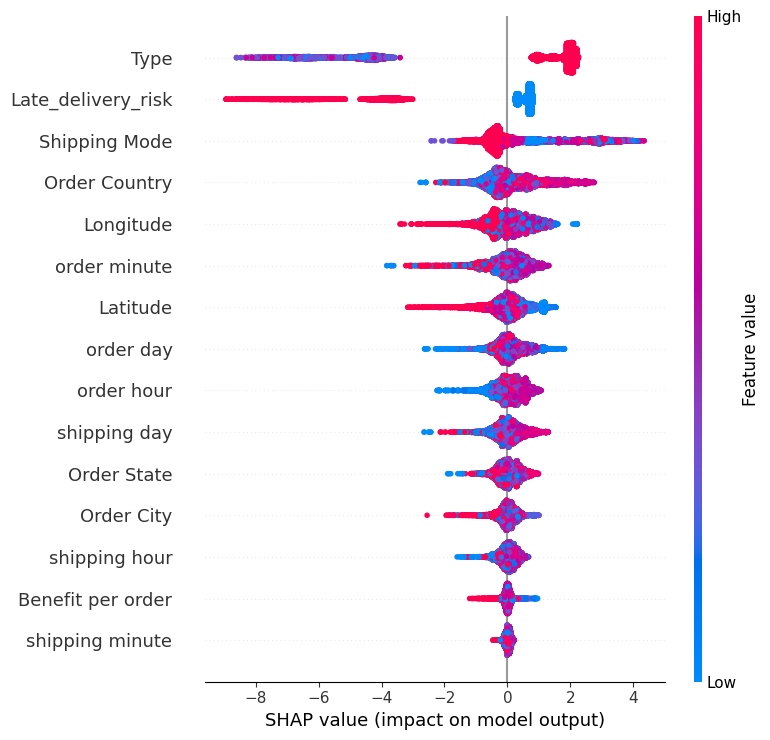

In [33]:
import shap

# Load JS visualization code to notebook
shap.initjs()

# retrieve model parameters
# best_xgb_model = grid_xgb.best_estimator_

# Explain the model's predictions using SHAP
explainer = shap.Explainer(xgb_model)

# Compute SHAP values
shap_values = explainer(X_resampled_sel)

shap.summary_plot(shap_values, X_resampled_sel)

In [34]:
# Load JS visualization code to the notebook
shap.initjs()

# Find indices where the label is 1
indices_label_1 = [i for i, label in enumerate(y_resampled) if label == 1]

instance_index = indices_label_1[0]  # Adjust this index to plot other instances
shap.force_plot(explainer.expected_value, shap_values.values[instance_index], feature_names=X_resampled_sel.columns)

In [35]:
indices_label_0 = [i for i, label in enumerate(y_resampled) if label == 0]

instance_index = indices_label_0[0]  # Adjust this index to plot other instances
shap.force_plot(explainer.expected_value, shap_values.values[instance_index], feature_names=X_resampled_sel.columns)

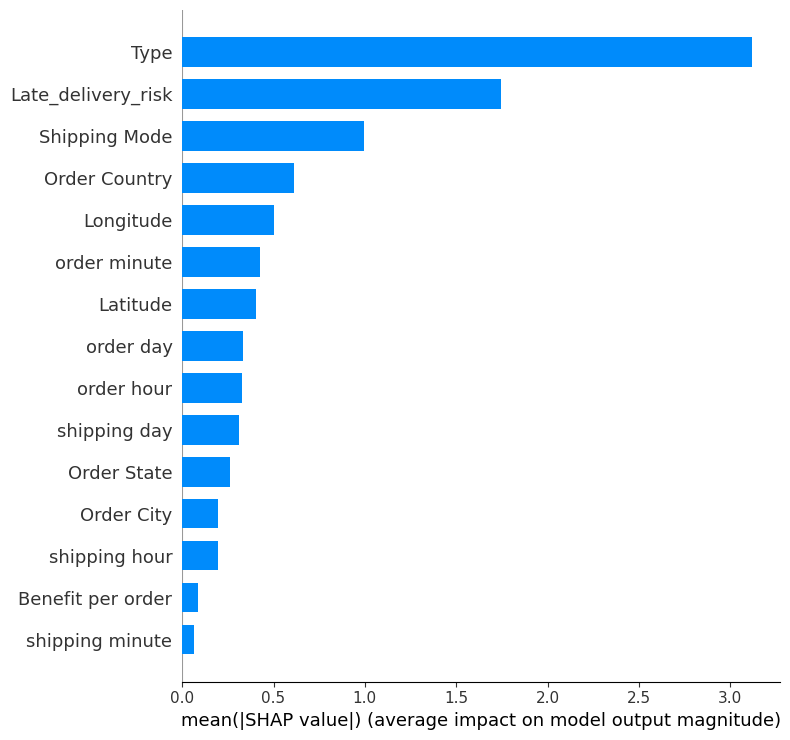

In [36]:
# Generate the summary plot
shap.summary_plot(shap_values, X_resampled_sel, plot_type="bar")
